# Topic Modelling

In [1]:
# include notebooks dataset processing cordis & nsf

## 0. Libraries

In [1]:
# Data processing
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Lemmatization
import spacy

# Vectorization
import gensim

# Topic modelling
from gensim.models.wrappers import LdaMallet
from customMallet import CustomMallet
mallet_path = '/Users/celiaromerogonzalez/Mallet/bin/mallet'
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel

# Document LDA representation
import pyLDAvis.gensim as gensimvis
import pyLDAvis

import warnings
warnings.filterwarnings('ignore')

## 1. Creating dataframe

Read CSVs corresponding to Cordis and NSF datasets. Only the columns of interest are imported.

### 1.1 Cordis dataset

In [4]:
cordish2020 = pd.read_csv("data/cordis/cordis-h2020projects.csv",sep=";",usecols=['id','objective'])
cordisfp6 = pd.read_csv("data/cordis/cordis-fp6projects.csv",sep=";",usecols=['id','objective'])
cordisfp7 = pd.read_csv("data/cordis/cordis-fp7projects.csv",sep=";",usecols=['id','objective'])
cordis = cordish2020.append(cordisfp7)
cordis = cordis.append(cordisfp6)

# cordis = pd.read_csv("data/cordis/cordis.csv",sep=";",usecols=['id','objective'])

print('Cordis null abstracts: %d (%.4f %%)' % (cordis['objective'].isnull().sum(),cordis['objective'].isnull().sum()/cordis.shape[0]))
print('Cordis shape with null abstracts: ',cordis.shape)
cordis = cordis[cordis['objective'].notna()]
print('Cordis shape without null abstracts: ',cordis.shape)
cordis['objective'].isnull().sum()

Cordis null abstracts: 160 (0.0024 %)
Cordis shape with null abstracts:  (68021, 2)
Cordis shape without null abstracts:  (67861, 2)


0

### 1.2 NSF dataset

In [5]:
nsf = pd.read_csv('data/nsf/nsf.csv',usecols=['AwardID','AbstractNarration'])

print('NSF null abstracts: %d (%.4f %%)' % (nsf['AbstractNarration'].isnull().sum(),nsf['AbstractNarration'].isnull().sum()/nsf.shape[0]))
print('NSF shape with null abstracts: ',nsf.shape)
nsf = nsf[nsf['AbstractNarration'].notna()]
print('NSF shape without null abstracts: ',nsf.shape)
nsf['AbstractNarration'].isnull().sum()

NSF null abstracts: 7857 (0.0114 %)
NSF shape with null abstracts:  (688506, 2)
NSF shape without null abstracts:  (680649, 2)


0

### 1.3 Join dataframes

In [7]:
# Add column with source of documents
cordis['org'] = 'EU'
nsf['org'] = 'NSF'

# Rename columns to match headers later
cordis = cordis.rename(columns={'objective':'abstract'})
nsf = nsf.rename(columns={'AwardID':'id','AbstractNarration':'abstract'})

# Join dataframes into 1
corpusdata = cordis.append(nsf)
corpusdata

,id,abstract,org
0,672890,'The project targets all luxury fashion firms ...,EU
1,633814,EU's agricultural and forestry land provides a...,EU
2,785419,"According to the Global Market Forecast, there...",EU
3,721362,In the aerospace industry very high quality st...,EU
4,861924,Large areas of agricultural land in W. and N. ...,EU
...,...,...,...
688501,1.61448e+06,A few micro-seconds after the Big Bang the uni...,NSF
688502,1.62455e+06,Calcium sulfate in crystalline form (anhydrite...,NSF
688503,1.6047e+06,The Rocky Mountain-Great Plains Graduate Resea...,NSF
688504,1.65392e+06,Investments made across national boundaries cr...,NSF


In [8]:
corpusdata.org.value_counts()

NSF    680649
EU      67861
Name: org, dtype: int64

## 2. Lemmatization with Spacy

... explain ...

### 2.1 Lemmatize

In [17]:
nlp = spacy.load('en_core_web_md')
nlp.disable_pipe('parser')
nlp.disable_pipe('ner')

valid_POS = set(['VERB', 'NOUN', 'ADJ', 'PROPN'])

def text_preprocessing(rawtext):
    lemmatized = ' '.join([token.lemma_ for token in doc 
                           if token.is_alpha
                           and token.pos_ in valid_POS
                           and not token.is_stop])
    return lemmatized

"""
corpusdata['lemmas'] = None

for i in range(len(corpusdata)):
    if not i%10000:
        print('Preprocessing abstract %d out of %d' % (i,len(corpusdata['abstract'])))
    doc = nlp(corpusdata['abstract'].iloc[i])
    corpusdata['lemmas'].iloc[i] = text_preprocessing(doc)

corpusdata.to_csv('data/corpusdata_lemmatized.csv',sep=';',index=False)

corpusdata.head()

"""

# OR

corpusdata = pd.read_csv('data/corpusdata_lemmatized.csv',sep=';')
corpusdata

,id,abstract,org,lemmas
0,672890,'The project targets all luxury fashion firms ...,EU,project target luxury fashion firm manufacture...
1,633814,EU's agricultural and forestry land provides a...,EU,EU agricultural forestry land provide wide ran...
2,785419,"According to the Global Market Forecast, there...",EU,accord Global Market Forecast strong need ramp...
3,721362,In the aerospace industry very high quality st...,EU,aerospace industry high quality standard meet ...
4,861924,Large areas of agricultural land in W. and N. ...,EU,large area agricultural land Africa degrade wa...
...,...,...,...,...
748505,1.61448e+06,A few micro-seconds after the Big Bang the uni...,NSF,micro second Big Bang universe fill hot plasma...
748506,1.62455e+06,Calcium sulfate in crystalline form (anhydrite...,NSF,calcium sulfate crystalline form anhydrite mel...
748507,1.6047e+06,The Rocky Mountain-Great Plains Graduate Resea...,NSF,Rocky Mountain Great Plains Graduate Research ...
748508,1.65392e+06,Investments made across national boundaries cr...,NSF,investment national boundary create internatio...


### 2.2 Count lemmas

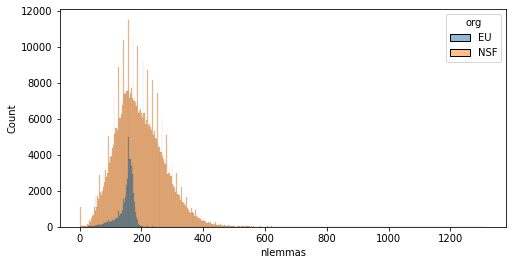

In [18]:
def count_lemmas(x):
    return len(x.split())

corpusdata = corpusdata[corpusdata['lemmas'].notna()]
corpusdata['lemmas'] = corpusdata['lemmas'].str.lower()
corpusdata['nlemmas'] = corpusdata['lemmas'].apply(count_lemmas)
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
sns.histplot(data = corpusdata, x='nlemmas', hue='org')
plt.show()

### 2.3 Remove documents with few lemmas

proportions in both datasets are similar

In [19]:
print('EU >= 100: ',len(corpusdata[(corpusdata['org']=='EU') & (corpusdata['nlemmas']>=100)]))
print('EU < 100: ',len(corpusdata[(corpusdata['org']=='EU') & (corpusdata['nlemmas']<100)]))

EU >= 100:  63236
EU < 100:  4622


In [20]:
print('NSF >= 100: ',len(corpusdata[(corpusdata['org']=='NSF') & (corpusdata['nlemmas']>=100)]))
print('NSF < 100: ',len(corpusdata[(corpusdata['org']=='NSF') & (corpusdata['nlemmas']<100)]))

NSF >= 100:  617115
NSF < 100:  63516


In [21]:
corpusdata = corpusdata[corpusdata['nlemmas']>=100]
print('Number of projects after removing short abstracts:', len(corpusdata))

Number of projects after removing short abstracts: 680351


## 3. Vectorization with Gensim

### 3.1 Dictionary

In [22]:
corpuslemmas = corpusdata.lemmas.tolist()
corpuslemmas = list(set(corpuslemmas)) # project order lost at this point
corpuslemmas = [el.split() for el in corpuslemmas]

# Create dictionary of tokens
D = gensim.corpora.Dictionary(corpuslemmas)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 238464 terms
First terms in the dictionary:
0 : additional
1 : advance
2 : alternative
3 : america
4 : aquatic
5 : bacterial
6 : bacterium
7 : benefit
8 : biochemistry
9 : biological


#### 3.1.1 Filter extremes in dictionary

In [23]:
no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .4 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

# D.filter_extremes(no_below=no_below,no_above=no_above, keep_n=25000)
D.filter_extremes(no_below=no_below,no_above=no_above) # keep all
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 57291 terms
First terms in the dictionary:
0 : additional
1 : advance
2 : alternative
3 : america
4 : aquatic
5 : bacterial
6 : bacterium
7 : benefit
8 : biochemistry
9 : biological


### 3.2 Create bag of words

In [24]:
corpusbow = [D.doc2bow(doc) for doc in corpuslemmas]

## 4. Topic modelling with Mallet

### 4.1 Initial topic model

20 topics

In [19]:
ldamallet = LdaMallet(mallet_path, corpus=corpusbow, num_topics=20, id2word=D, alpha=5, iterations=100)

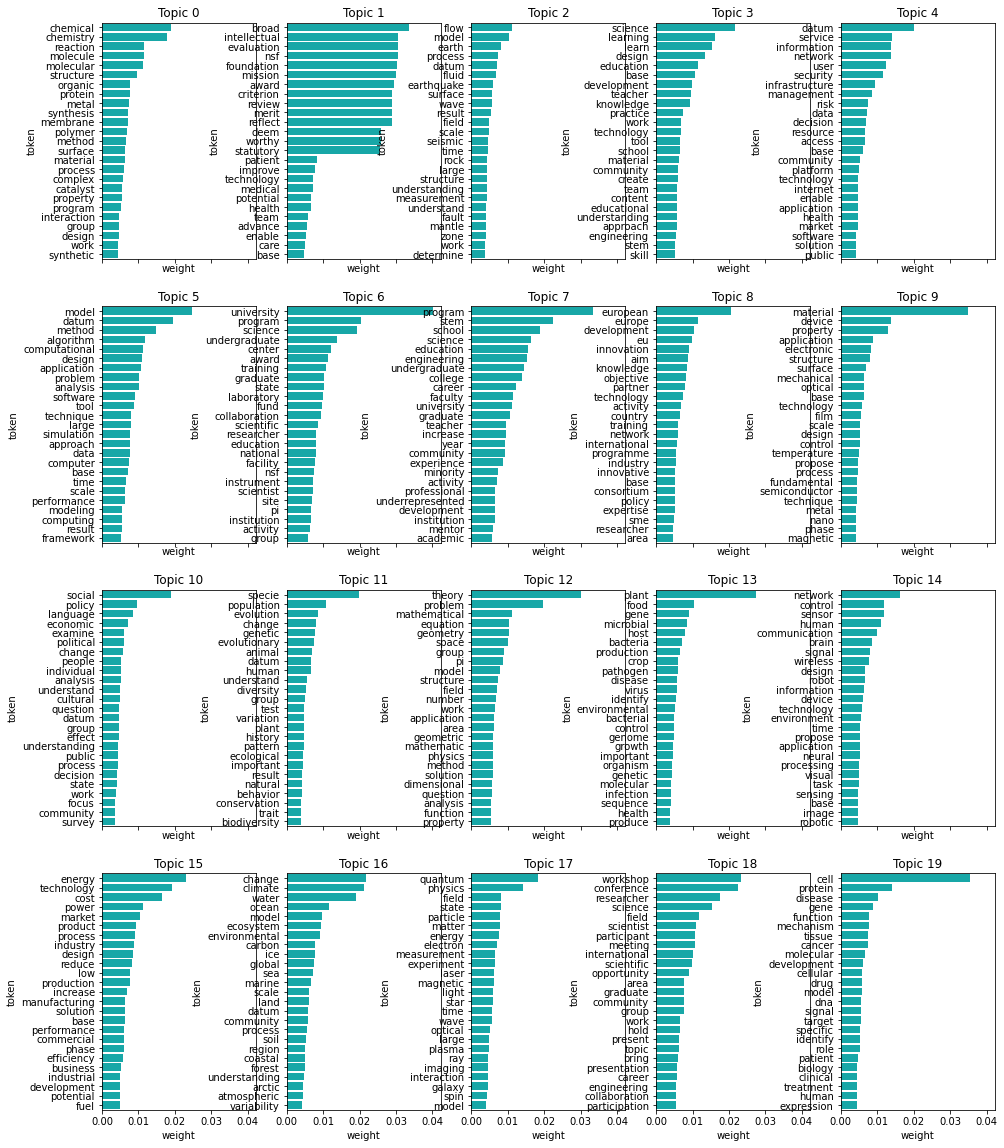

In [20]:
topn = 25 # top 25 words in each topic

fig, axes = plt.subplots(4, 5, figsize=(16, 20), sharex=True)

for i in range(5):

    # Build a dataframe with columns 'token' and 'weight' for topic i
    df = pd.DataFrame(ldamallet.show_topic(i, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 5
    df = pd.DataFrame(ldamallet.show_topic(i+5, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[1][i])
    axes[1][i].set_title('Topic ' + str(i+5))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 10
    df = pd.DataFrame(ldamallet.show_topic(i+10, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[2][i])
    axes[2][i].set_title('Topic ' + str(i+10))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 15
    df = pd.DataFrame(ldamallet.show_topic(i + 15, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[3][i])
    axes[3][i].set_title('Topic ' + str(i + 15))
    
plt.show()

In [21]:
mytopics20 = pd.DataFrame(columns=['topic','word'])

for i in range(len(ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False))):
    for j in range(len(ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False)[i][1])):
        new_row = {'topic':ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False)[i][0],
                   'word':ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False)[i][1][j][0]}
        mytopics20 = mytopics20.append(new_row,ignore_index=True)
        
mytopics20.to_excel('data/mytopics20.xlsx',index=False)

### 4.2 Cleaning vocabulary

In [36]:
specific_stw = ['activity','aim','analysis','application','approach','area','attend','award',
                'base','bring','broad',
                'center','challenge','change','collaboration','collaborative','collection','community','complex','concept','condition','conference','content','context','cost','create','current',
                'data','datum','deem','design','development','discuss','discussion',
                'effect','enable','engineering','establish','eu','evaluation','examine','experience',
                'field','focus','foundation','formation','framework','function','fundamental',
                'goal','group',
                'hold','human',
                'identify','important','improve','increase','information','innovation','intellectual','interaction','international','issue',
                'key','knowledge',
                'large','learn','learning','long','low',
                'main','management','material','mechanism','merit','meeting','method','middle','mission','model','modeling',
                'national','network','nsf','number',
                'objective','open','opportunity','outreach',
                'participant','participant','participation','performance','phase','potential','practice','present','presentation','problem','process','professional','programme','program','property','propose','public',
                'question',
                'real','reduce','reflect','researcher','resolution','response','result','review','role',
                'scale','science','scientist','scientific','service','session','small','solution','solve','specific','state','structure',
                'target','team','technique','technology','test','theory','time','tool','topic','type',
                'underrepresented','understand','understanding','university',
                'week','work','workshop','worthy',
                'year']

In [37]:
# count how many stopwords appear in each document
def count_stopwords(doc):
    stws = doc.lower().split()
    stws = [sw for sw in stws if sw in specific_stw]
    return len(stws)

corpusdata['nstopwords'] = corpusdata['lemmas'].apply(count_stopwords)
corpusdata

,id,abstract,org,lemmas,nlemmas,nstopwords
0,672890,'The project targets all luxury fashion firms ...,EU,project target luxury fashion firm manufacture...,152,33
1,633814,EU's agricultural and forestry land provides a...,EU,eu agricultural forestry land provide wide ran...,176,35
2,785419,"According to the Global Market Forecast, there...",EU,accord global market forecast strong need ramp...,167,35
3,721362,In the aerospace industry very high quality st...,EU,aerospace industry high quality standard meet ...,149,23
4,861924,Large areas of agricultural land in W. and N. ...,EU,large area agricultural land africa degrade wa...,188,32
...,...,...,...,...,...,...
748505,1.61448e+06,A few micro-seconds after the Big Bang the uni...,NSF,micro second big bang universe fill hot plasma...,206,30
748506,1.62455e+06,Calcium sulfate in crystalline form (anhydrite...,NSF,calcium sulfate crystalline form anhydrite mel...,284,25
748507,1.6047e+06,The Rocky Mountain-Great Plains Graduate Resea...,NSF,rocky mountain great plains graduate research ...,179,59
748508,1.65392e+06,Investments made across national boundaries cr...,NSF,investment national boundary create internatio...,164,29


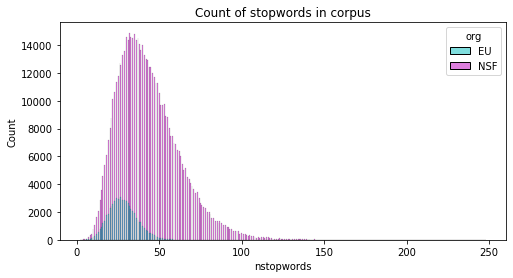

In [38]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
sns.histplot(data = corpusdata, x='nstopwords', hue='org', palette=['c','m'])
plt.title('Count of stopwords in corpus')
plt.show()

In [39]:
def clean_lemmas(orig_str):
    lemmas = orig_str.lower().split()
    lemmas = [el for el in lemmas if el not in specific_stw]
    return ' '.join(lemmas)

corpusdata['clean_lemmas'] = corpusdata['lemmas'].apply(clean_lemmas)
corpusdata

#### 4.2.1 Remove again documents with few lemmas

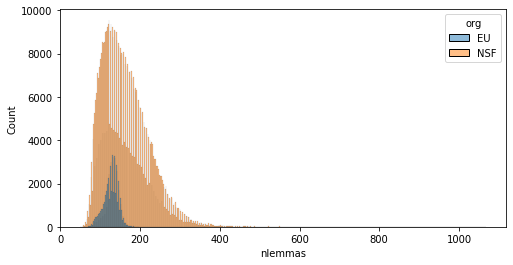

In [41]:
# filter again according to the number of lemmas
corpusdata['nlemmas'] = corpusdata['clean_lemmas'].apply(count_lemmas)
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
sns.histplot(data = corpusdata, x='nlemmas', hue='org')
plt.show()

In [42]:
print('There are ',len(corpusdata[corpusdata['nlemmas']<100]),' short documents.')
corpusdata = corpusdata[corpusdata['nlemmas']>=100]
print('Number of projects after applying specific stopwords and removing short texts:', len(corpusdata))

There are  74728  short documents.
Number of projects after applying specific stopwords and removing short texts: 605623


#### 4.2.2 Create dictionary again

In [44]:
mycorpus = corpusdata.clean_lemmas.tolist()
mycorpus = list(set(mycorpus)) # project order lost at this point
mycorpus = [el.split() for el in mycorpus]

# Create dictionary of tokens
D = gensim.corpora.Dictionary(mycorpus)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

    
print('\nFiltering extremes...\n')
no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .4 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

#D.filter_extremes(no_below=no_below,no_above=no_above, keep_n=25000)
D.filter_extremes(no_below=no_below,no_above=no_above) # keep all
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 229083 terms
First terms in the dictionary:
0 : achieve
1 : address
2 : advance
3 : alternative
4 : art
5 : behavior
6 : blend
7 : chicago
8 : code
9 : coherence

Filtering extremes...

The dictionary contains 54902 terms
First terms in the dictionary:
0 : achieve
1 : address
2 : advance
3 : alternative
4 : art
5 : behavior
6 : blend
7 : chicago
8 : code
9 : coherence


In [45]:
#corpusdata.to_csv('data/corpusdata_clean_2.csv',sep=';',index=False)
#D.save('data/clean_gensim_2.dict')
corpusdata.to_csv('data/corpusdata_clean_3.csv',sep=';',index=False)
D.save('data/clean_gensim_3.dict')

In [2]:
#corpusdata = pd.read_csv('data/corpusdata_clean_2.csv',sep=';')
#D = gensim.corpora.Dictionary.load('data/clean_gensim_2.dict')
corpusdata = pd.read_csv('data/corpusdata_clean_3.csv',sep=';')
D = gensim.corpora.Dictionary.load('data/clean_gensim_3.dict')

#### 4.2.3 Create again bag of words

In [3]:
mycorpus = corpusdata.clean_lemmas.tolist()
mycorpus = list(set(mycorpus)) # at this point project order is lost
mycorpus = [el.split() for el in mycorpus]
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]

### 4.3 Validating number of topics using coherence

#### 4.3.1 First round with wide range

Estimating coherence for a model with 5 topics
[0.5699351952294437]
Estimating coherence for a model with 10 topics
[0.5699351952294437, 0.6300615443736619]
Estimating coherence for a model with 15 topics
[0.5699351952294437, 0.6300615443736619, 0.6555099037874522]
Estimating coherence for a model with 20 topics
[0.5699351952294437, 0.6300615443736619, 0.6555099037874522, 0.6535890026594041]
Estimating coherence for a model with 25 topics
[0.5699351952294437, 0.6300615443736619, 0.6555099037874522, 0.6535890026594041, 0.6659062649671885]
Estimating coherence for a model with 35 topics
[0.5699351952294437, 0.6300615443736619, 0.6555099037874522, 0.6535890026594041, 0.6659062649671885, 0.665048864609245]
Estimating coherence for a model with 50 topics
[0.5699351952294437, 0.6300615443736619, 0.6555099037874522, 0.6535890026594041, 0.6659062649671885, 0.665048864609245, 0.663425551188209]
Estimating coherence for a model with 75 topics
[0.5699351952294437, 0.6300615443736619, 0.6555099037

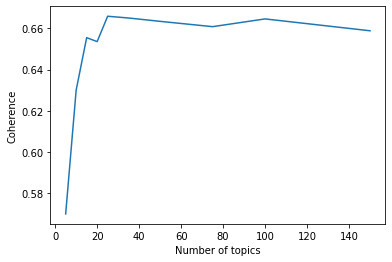

Maximum coherence (0.665906) is achieved with 25 topics


In [6]:
n_topics = [5, 10, 15, 20, 25, 35, 50, 75, 100, 150]

tc = []
for ntpc in n_topics:
    print('Estimating coherence for a model with', ntpc, 'topics')
    lda_ntpc = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=ntpc, id2word=D, alpha=5, iterations=250)
    ldagensim = malletmodel2ldamodel(lda_ntpc)
    tc.append(CoherenceModel(ldagensim, texts=mycorpus, dictionary=D, coherence='c_v').get_coherence())
    print(tc)
    
plt.plot(n_topics, tc)
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.show()

print('Maximum coherence (%f) is achieved with %d topics' % (max(tc),n_topics[tc.index(max(tc))]))

In [48]:
tcfile = open("data/tc1.txt","w")
tcfile.write(str((tc)))
tcfile.close()

#### 4.3.2 Second round with adjusted range

Estimating coherence for a model with 30 topics
[0.6649281633129581]
Estimating coherence for a model with 40 topics
[0.6649281633129581, 0.6668348184139163]
Estimating coherence for a model with 60 topics
[0.6649281633129581, 0.6668348184139163, 0.6667305851929881]
Estimating coherence for a model with 80 topics
[0.6649281633129581, 0.6668348184139163, 0.6667305851929881, 0.6576659893966683]


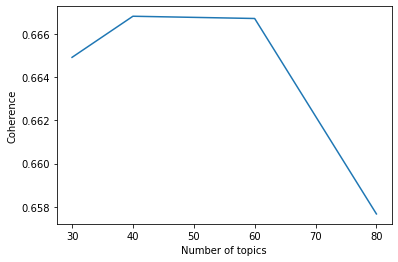

Maximum coherence (0.666835) is achieved with 40 topics


In [51]:
n_topics = [30,40,60,80]

tc = []
for ntpc in n_topics:
    print('Estimating coherence for a model with', ntpc, 'topics')
    lda_ntpc = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=ntpc, id2word=D, alpha=5, iterations=250)
    ldagensim = malletmodel2ldamodel(lda_ntpc)
    tc.append(CoherenceModel(ldagensim, texts=mycorpus, dictionary=D, coherence='c_v').get_coherence())
    print(tc)
    
plt.plot(n_topics, tc)
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.show()

print('Maximum coherence (%f) is achieved with %d topics' % (max(tc),n_topics[tc.index(max(tc))]))

In [11]:
tcfile = open("data/tc2.txt","w")
tcfile.write(str((tc)))
tcfile.close()

#### 4.3.3 Third round with even more adjusted range

Estimating coherence for a model with 25 topics
[0.658530715693794]
Estimating coherence for a model with 30 topics
[0.658530715693794, 0.6609624193774647]
Estimating coherence for a model with 35 topics
[0.658530715693794, 0.6609624193774647, 0.6641689963105258]
Estimating coherence for a model with 40 topics
[0.658530715693794, 0.6609624193774647, 0.6641689963105258, 0.6663624505448446]
Estimating coherence for a model with 45 topics
[0.658530715693794, 0.6609624193774647, 0.6641689963105258, 0.6663624505448446, 0.6695660733663734]
Estimating coherence for a model with 50 topics
[0.658530715693794, 0.6609624193774647, 0.6641689963105258, 0.6663624505448446, 0.6695660733663734, 0.6643076468096164]
Estimating coherence for a model with 55 topics
[0.658530715693794, 0.6609624193774647, 0.6641689963105258, 0.6663624505448446, 0.6695660733663734, 0.6643076468096164, 0.667548665579401]


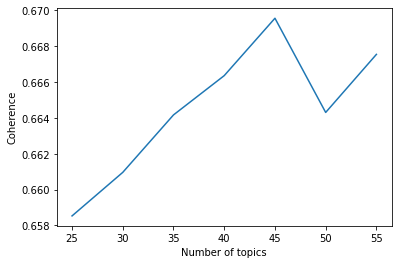

Maximum coherence (0.669566) is achieved with 45 topics


In [52]:
n_topics = [25,30,35,40,45,50,55]

tc = []
for ntpc in n_topics:
    print('Estimating coherence for a model with', ntpc, 'topics')
    lda_ntpc = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=ntpc, id2word=D, alpha=5, iterations=250)
    ldagensim = malletmodel2ldamodel(lda_ntpc)
    tc.append(CoherenceModel(ldagensim, texts=mycorpus, dictionary=D, coherence='c_v').get_coherence())
    print(tc)
    
plt.plot(n_topics, tc)
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.show()

print('Maximum coherence (%f) is achieved with %d topics' % (max(tc),n_topics[tc.index(max(tc))]))

In [53]:
tcfile = open("data/tc3.txt","w")
tcfile.write(str((tc)))
tcfile.close()

In [ ]:
n_topics = [5, 10, 15, 20, 25, 35, 50, 75, 100, 150]
iterations = 3 #10, 20...
tc = pd.DataFrame(columns=['ntpcs','mean','sd'])

for ntpc in n_topics:
    print('Estimating coherence for a model with', ntpc, 'topics')
    coherences = np.array([])
    for i in range(iterations):
        #lda_ntpc = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=ntpc, id2word=D, alpha=5, iterations=250)
        lda_ntpc = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=ntpc, id2word=D, alpha=5, iterations=100)
        ldagensim = malletmodel2ldamodel(lda_ntpc)
        coherence = CoherenceModel(ldagensim, texts=mycorpus, dictionary=D, coherence='c_v').get_coherence()
        coherences = np.append(coherences,coherence)
    print(coherences)
    tc.loc[n_topics.index(ntpc)] = [ntpc,np.mean(coherences),np.std(coherences)]

tc.to_csv('data/tc3.csv',sep=';',index=False)
    
plt.plot(n_topics, tc['mean'])
plt.fill_between(range(1,len(n_topics)+1),tc['mean']-tc['sd'],tc['mean']+tc['sd'],alpha=0.2)
plt.xlabel('Number of topics')
plt.ylabel('Average coherence')
plt.show()

print('Maximum coherence (%f) is achieved with %d topics' % (tc['mean'].max(),n_topics[tc['mean'].idxmax()]))

### 4.4 Document LDA representation

In [ ]:
#mycorpus = pd.read_excel('corpusdata_clean_2.xlsx')
#mycorpus_bow = gensim.corpora.Dictionary.load('clean_gensim_2.dict')

#mycorpus = pd.read_excel('corpusdata_clean_3.xlsx')
#mycorpus_bow = gensim.corpora.Dictionary.load('clean_gensim_3.dict')

In [4]:
ldamallet = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=45, id2word=D, alpha=5, iterations=1000)

In [5]:
mytopics = pd.DataFrame(columns=['topic','word'])
topn = 45

for i in range(len(ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False))):
    for j in range(len(ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False)[i][1])):
        new_row = {'topic':ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False)[i][0],
                   'word':ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False)[i][1][j][0]}
        mytopics = mytopics.append(new_row,ignore_index=True)
        
mytopics.to_excel('data/mytopics45.xlsx',index=False)

In [7]:
ldagensim = malletmodel2ldamodel(ldamallet)
vis_data = gensimvis.prepare(ldagensim, mycorpus_bow, D)
pyLDAvis.display(vis_data)

In [9]:
tpc_descriptions = []

for ntpc in range(45):
    print(ldagensim.show_topic(ntpc, topn=20))
    desc = input('Introduce a label for topic ' + str(ntpc) + ': ')
    tpc_descriptions.append(desc)

[('undergraduate', 0.029290219385762664), ('laboratory', 0.018633880950725136), ('graduate', 0.018545613087181907), ('facility', 0.01380589629328469), ('instrument', 0.013634710133685694), ('pi', 0.01355179183762993), ('school', 0.013531730959551923), ('training', 0.013250878666459819), ('education', 0.0127506941063815), ('fund', 0.011720902365043789), ('institution', 0.011180596048809456), ('college', 0.010708496718040347), ('instrumentation', 0.009621197126212348), ('faculty', 0.008561982763693557), ('department', 0.007667267601414426), ('lab', 0.007478695347481157), ('enhance', 0.007311521363497762), ('summer', 0.006888905531987739), ('educational', 0.006866169870165998), ('california', 0.006555894955892817)]


Introduce a label for topic 0:  Undergraduate education


[('software', 0.03117084770182984), ('computing', 0.02499149729420223), ('computer', 0.015060910944740305), ('architecture', 0.010612237869114298), ('resource', 0.010256344023064218), ('hardware', 0.010134364277442213), ('memory', 0.009309207174705132), ('code', 0.009157091256635339), ('level', 0.00805353332271392), ('cloud', 0.007968865028693942), ('distribute', 0.007559874116902518), ('simulation', 0.007097786139369752), ('computational', 0.0070389488503050214), ('parallel', 0.007026033347827397), ('programming', 0.006971501226255208), ('platform', 0.006889703043896923), ('storage', 0.0065610752586329375), ('infrastructure', 0.006121948174393725), ('computation', 0.006101857392761865), ('algorithm', 0.006055935606174758)]


Introduce a label for topic 1:  Cloud computing


[('ecosystem', 0.023407707259087914), ('forest', 0.018715563908566657), ('soil', 0.018029653189404526), ('water', 0.01800877066165486), ('climate', 0.017089939440669527), ('land', 0.013350360625190754), ('plant', 0.013104589337060062), ('river', 0.010740044656482418), ('environmental', 0.009623632596019468), ('lake', 0.009281480410582622), ('ecological', 0.009175461423545854), ('landscape', 0.008831702889820572), ('tree', 0.008783512441167493), ('fire', 0.006757907249449826), ('carbon', 0.006418967760589851), ('term', 0.006012561643615568), ('stream', 0.005974009284693107), ('site', 0.005458371484105184), ('dynamic', 0.005363596935087466), ('specie', 0.005265609689492876)]


Introduce a label for topic 2:  Environmental biology


[('patient', 0.029234006419180517), ('health', 0.021285526091600067), ('disease', 0.02088242261036516), ('treatment', 0.01886967567485202), ('clinical', 0.018781020613686954), ('drug', 0.015535414233847114), ('cancer', 0.014508954853795334), ('medical', 0.013688895538018473), ('care', 0.012183144733543054), ('therapy', 0.009149479359300954), ('risk', 0.007586933906266665), ('healthcare', 0.006764104119828395), ('diagnostic', 0.006615883939443051), ('blood', 0.006471819465049818), ('life', 0.005745956151760841), ('diagnosis', 0.005683620561879154), ('therapeutic', 0.005543711793478034), ('lead', 0.005450901026320855), ('device', 0.005450901026320855), ('early', 0.0050658056043851)]


Introduce a label for topic 3:  Medicine


[('water', 0.04195823696340403), ('carbon', 0.022794153831012253), ('gas', 0.013408132801863426), ('organic', 0.012742155077670063), ('environmental', 0.012647015402785296), ('microbial', 0.011308498597509965), ('nitrogen', 0.010475206272657186), ('chemical', 0.010325935403441431), ('concentration', 0.008838147728950347), ('environment', 0.007714515361776815), ('source', 0.007127273920246707), ('oxygen', 0.006704066400931713), ('iron', 0.006331709397503404), ('air', 0.006000360874628873), ('treatment', 0.005796958811082132), ('compound', 0.00533438315043551), ('rate', 0.005232682118662139), ('production', 0.005170349228220396), ('emission', 0.005168708888998245), ('dioxide', 0.005085051588668537)]


Introduce a label for topic 4:  Geophysics


[('robot', 0.020921290448642348), ('control', 0.019335445467170042), ('robotic', 0.01449242492969246), ('environment', 0.01423073433869043), ('task', 0.011463792489828959), ('object', 0.010406562502180755), ('user', 0.009342354098772496), ('computer', 0.00908240811171048), ('motion', 0.008946329004389424), ('virtual', 0.008721275096127678), ('vision', 0.008011221292542166), ('device', 0.007707660206979812), ('physical', 0.007405843725357469), ('people', 0.007370951646557199), ('movement', 0.0072348725392361425), ('visual', 0.007175556005275682), ('interface', 0.006137516660967627), ('machine', 0.0060555202757869905), ('feedback', 0.005432696669202158), ('world', 0.005355934095841562)]


Introduce a label for topic 5:  Robotics


[('graduate', 0.018963573299518307), ('career', 0.014324526699621016), ('reu', 0.012869983331564165), ('faculty', 0.00996376551728095), ('summer', 0.009946551986298029), ('site', 0.009544902930029865), ('young', 0.009081572054406234), ('undergraduate', 0.0090342348442032), ('participate', 0.008611068874206384), ('mentor', 0.008510656610139344), ('symposium', 0.006710408161508823), ('encourage', 0.006462246423171708), ('travel', 0.006310193566155903), ('fellow', 0.006064900749649274), ('postdoctoral', 0.005826780237718863), ('school', 0.005753622731041447), ('woman', 0.005605873256771372), ('training', 0.0055900941867036945), ('doctoral', 0.005502592070873845), ('seminar', 0.005399310884976317)]


Introduce a label for topic 6:  Graduate education


[('geometry', 0.02082207383903718), ('space', 0.020617223684745785), ('geometric', 0.012121027214560926), ('algebraic', 0.011151984286104479), ('pi', 0.011016870354550581), ('equation', 0.009919977684408726), ('mathematic', 0.009888015248987374), ('mathematical', 0.009799392132591806), ('algebra', 0.009331578305061108), ('manifold', 0.00927637046206059), ('dimensional', 0.008965463135689257), ('topology', 0.008026929804680465), ('object', 0.007605606792308096), ('representation', 0.006890810509248767), ('conjecture', 0.006632205349930555), ('invariant', 0.006218146527426676), ('physics', 0.005950824340266277), ('investigator', 0.005840408654265243), ('surface', 0.005772125269501445), ('variety', 0.005657351069579317)]


Introduce a label for topic 7:  Geometric analysis


[('ocean', 0.03822998581926003), ('ice', 0.026264986463839117), ('sea', 0.023394998066262735), ('marine', 0.023340208843625115), ('arctic', 0.013038223540028364), ('climate', 0.012427484852391391), ('coastal', 0.01210036096429032), ('water', 0.01029876240814748), ('coral', 0.007838081732628595), ('global', 0.006890550470542736), ('ecosystem', 0.006737462936702334), ('level', 0.006673005027716902), ('region', 0.005914013149413434), ('antarctic', 0.005878561299471446), ('deep', 0.005546603068196468), ('sheet', 0.005290382879979375), ('reef', 0.005196918911950497), ('atlantic', 0.005151798375660694), ('pacific', 0.004856903442052341), ('shelf', 0.00484562330797989)]


Introduce a label for topic 8:  Arctic and Antartic research (polar programs)


[('economic', 0.022135350382760755), ('policy', 0.021057546644853133), ('decision', 0.018743954907781073), ('market', 0.015751030847304698), ('firm', 0.009173619436979199), ('financial', 0.008715465079334428), ('individual', 0.00743930332451547), ('choice', 0.007114557898598678), ('level', 0.0065300161319484535), ('risk', 0.006426448671791206), ('economy', 0.006194738421947874), ('trade', 0.006015689592523481), ('game', 0.005913877513046865), ('worker', 0.005494341530375984), ('labor', 0.005431147825873257), ('agent', 0.005420615541789469), ('country', 0.005411838638386313), ('outcome', 0.005404817115663788), ('price', 0.00535391107592548), ('behavior', 0.005104647019275835)]


Introduce a label for topic 9:  Decision, risk and management sciences


[('climate', 0.03282690065891942), ('atmospheric', 0.016368318862456575), ('weather', 0.013328186425607019), ('cloud', 0.010990952581231839), ('observation', 0.010069118361593314), ('atmosphere', 0.00996541201188398), ('global', 0.009060862183863675), ('wind', 0.008830403628954044), ('variability', 0.008657559712771821), ('surface', 0.008409816766243968), ('region', 0.00798922990353389), ('aerosol', 0.007703077197854431), ('measurement', 0.007641621583211863), ('earth', 0.007411163028302231), ('precipitation', 0.006696741508082374), ('temperature', 0.006500851736409186), ('storm', 0.006128277072638616), ('radar', 0.00608602633757185), ('simulation', 0.005915102909347207), ('satellite', 0.0057345770413346625)]


Introduce a label for topic 10:  Atmospheric sciences


[('environmental', 0.02164093071589784), ('urban', 0.019840226021725367), ('risk', 0.015740334810917894), ('social', 0.015436699303424426), ('decision', 0.014834299446311724), ('city', 0.014605355026223068), ('policy', 0.014293600922272559), ('local', 0.014064656502183904), ('economic', 0.01130758114537159), ('resource', 0.011060775813077437), ('health', 0.009212983259454107), ('disaster', 0.008623573156672676), ('natural', 0.008063390001136605), ('infrastructure', 0.007853930212544857), ('environment', 0.007355448390082324), ('sustainability', 0.007217432250312567), ('water', 0.006785522918797799), ('strategy', 0.006563073375874779), ('stakeholder', 0.006563073375874779), ('resilience', 0.006464026499098836)]


Introduce a label for topic 11:  Environmental research


[('device', 0.03085510357002248), ('electronic', 0.02275365447872084), ('magnetic', 0.017085561157749018), ('film', 0.013359326382097816), ('semiconductor', 0.013124372928282045), ('thin', 0.008860920255527757), ('electron', 0.008688197716506432), ('spin', 0.008105259147309465), ('layer', 0.0070651138571737005), ('metal', 0.0069292218595613355), ('nanoscale', 0.006898741411498749), ('transport', 0.006736179021831621), ('electrical', 0.0066942684057455645), ('control', 0.006428834503867207), ('growth', 0.006228171554121846), ('silicon', 0.006173560751343045), ('graphene', 0.0059030467747875895), ('crystal', 0.00577731492652942), ('surface', 0.00576588475850595), ('oxide', 0.005759534665159578)]


Introduce a label for topic 12:  Electronic devices


[('user', 0.020850904686720042), ('web', 0.0163646349878963), ('digital', 0.013181840231214232), ('database', 0.012812548410871573), ('access', 0.01033704137789663), ('video', 0.010335476582047722), ('image', 0.009859778643979212), ('online', 0.009637577633434053), ('medium', 0.00909772306556025), ('source', 0.008298112386767458), ('search', 0.008060263417733204), ('software', 0.008057133826035385), ('visualization', 0.00781772006115222), ('resource', 0.007410873140435732), ('text', 0.006198156357530813), ('set', 0.005770967090778501), ('interactive', 0.005508081388161693), ('platform', 0.005367249761759831), ('exist', 0.005035513041791002), ('query', 0.004968226820287891)]


Introduce a label for topic 13:  Multimedia


[('vehicle', 0.02183984856036242), ('control', 0.017664977795855973), ('safety', 0.015179722822552349), ('transport', 0.010432707028220608), ('operation', 0.010063941676966025), ('aircraft', 0.008868247962292068), ('traffic', 0.008725211704835745), ('transportation', 0.007753012142437294), ('road', 0.0071428731067251635), ('air', 0.006570728076899869), ('flight', 0.006327119450919567), ('space', 0.005377269303748668), ('car', 0.00527222705217918), ('autonomous', 0.005247642695428875), ('engine', 0.005113546204063572), ('level', 0.004963805122038983), ('noise', 0.004659853074944295), ('sensor', 0.0045928048292616435), ('driver', 0.004438593864191544), ('maintenance', 0.004338021495667567)]


Introduce a label for topic 14:  Aerospace engineering


[('polymer', 0.03087981271535788), ('surface', 0.017360352296302506), ('nanoparticle', 0.01660444801025036), ('membrane', 0.013639207632687398), ('assembly', 0.012293548319497541), ('molecular', 0.010548232680810808), ('control', 0.009632166496525834), ('particle', 0.008853809607917686), ('liquid', 0.008579887856734433), ('chemical', 0.006906420546226915), ('separation', 0.006864509021455707), ('nano', 0.006334627601134006), ('size', 0.006129560497789167), ('molecule', 0.005726910491951491), ('nanotechnology', 0.005616144319341869), ('pi', 0.005170085948562584), ('block', 0.00509674078021297), ('chemistry', 0.005048841894760161), ('crystal', 0.0049470567631729415), ('nanomaterial', 0.004857246352948924)]


Introduce a label for topic 15:  Nanoscale interactions


[('earthquake', 0.02202373725456956), ('fault', 0.020211715601941672), ('seismic', 0.01775368875836427), ('zone', 0.01486041019038826), ('plate', 0.012532958864130443), ('mantle', 0.010441459788467656), ('deformation', 0.010404807011676195), ('earth', 0.009536594361428447), ('tectonic', 0.008013213326033318), ('subduction', 0.007580252400184177), ('region', 0.007264122200357819), ('slip', 0.007140419078686636), ('surface', 0.006689131764441764), ('rock', 0.006439434722549931), ('wave', 0.005763649150457355), ('hazard', 0.005312361836212483), ('event', 0.005103899168211044), ('boundary', 0.005028302816078654), ('crust', 0.0048015137596814856), ('observation', 0.00467322904091137)]


Introduce a label for topic 16:  Tectonics


[('building', 0.02621648788043568), ('damage', 0.016774597525005354), ('structural', 0.015758454583903198), ('wind', 0.01551128467931078), ('construction', 0.014898852582376236), ('failure', 0.012336524571434849), ('testing', 0.008280191803845963), ('infrastructure', 0.008109919202904521), ('concrete', 0.00802752923470705), ('soil', 0.007807822652847123), ('bridge', 0.007077298268162869), ('load', 0.006854845354029694), ('earthquake', 0.006094111314339699), ('fire', 0.005553083856509632), ('turbine', 0.005434991568759921), ('experimental', 0.005371825926475193), ('civil', 0.005366333261928694), ('site', 0.005017549063226062), ('repair', 0.004954383420941333), ('exist', 0.00478411081999989)]


Introduce a label for topic 17:  Natural hazards engineering research infrastructure


[('security', 0.04487612126080976), ('privacy', 0.014574930931968865), ('user', 0.013381566133661527), ('attack', 0.013334859096545781), ('cyber', 0.012998568429312402), ('secure', 0.011758496593889318), ('internet', 0.00985284947956684), ('detection', 0.008636131162701628), ('cybersecurity', 0.008418943440113404), ('device', 0.007888818568849676), ('mobile', 0.0077930691427623945), ('ai', 0.007524503679346849), ('threat', 0.007258273567787091), ('smart', 0.00699437880808312), ('control', 0.006781861789206471), ('infrastructure', 0.0066791063075518275), ('trust', 0.00643856506640573), ('physical', 0.006391858029289983), ('critical', 0.006263413677221679), ('iot', 0.0056188565650243695)]


Introduce a label for topic 18:  Cybersecurity


[('chemistry', 0.03790132087882085), ('chemical', 0.034243014675971704), ('reaction', 0.027963359022833735), ('molecule', 0.018361856538688003), ('metal', 0.01668645433874013), ('catalyst', 0.01498485243360788), ('synthesis', 0.013605920581798929), ('molecular', 0.012488985781833677), ('organic', 0.011300346525574361), ('professor', 0.010113086201166854), ('compound', 0.008063993469378751), ('catalytic', 0.0071111515597787655), ('bond', 0.006640935798311913), ('catalysis', 0.006458916793873131), ('division', 0.006348602245728415), ('synthetic', 0.005608115841307008), ('ion', 0.00560535797760339), ('spectroscopy', 0.005314403356871701), ('carbon', 0.0051048057153967406), ('hydrogen', 0.004968291462067654)]


Introduce a label for topic 19:  Chemistry


[('optical', 0.027625674904345872), ('laser', 0.019825869899470997), ('imaging', 0.019574615676624888), ('light', 0.01950907109675199), ('detection', 0.011703804043554372), ('image', 0.011104344240133492), ('sensor', 0.010776621340769), ('device', 0.008914062862714145), ('measurement', 0.008893580181503864), ('photonic', 0.008052424739801672), ('single', 0.007730163888759922), ('optic', 0.006812539770539348), ('range', 0.0067265125094561696), ('frequency', 0.006695105731600406), ('sensing', 0.006512127112788565), ('pulse', 0.006494375455739655), ('source', 0.006183038701343389), ('sensitivity', 0.006161190508052423), ('instrument', 0.006053315053678278), ('probe', 0.006046487493274851)]


Introduce a label for topic 20:  Optical physics


[('specie', 0.03379095931259348), ('population', 0.016385473629482665), ('evolution', 0.013212361846653139), ('evolutionary', 0.012812517121630902), ('animal', 0.012296099590479734), ('genetic', 0.008193902542802622), ('diversity', 0.008185742446373597), ('behavior', 0.007213525243258304), ('ecological', 0.006266954057491377), ('variation', 0.006099089216665715), ('natural', 0.006043134269723828), ('trait', 0.005947544568698104), ('organism', 0.005928892919717475), ('insect', 0.005860114964101405), ('biology', 0.005771519631443417), ('pattern', 0.005681758570724139), ('fish', 0.005603654790617755), ('history', 0.005566351492656497), ('life', 0.005522053826327503), ('individual', 0.005506899361530742)]


Introduce a label for topic 21:  Evolutionary processes


[('language', 0.0331345007962876), ('brain', 0.029425938869367334), ('neural', 0.014553392759687098), ('cognitive', 0.012604961557978989), ('memory', 0.009933648018536426), ('speech', 0.009014486370556187), ('child', 0.008171921526574302), ('neuron', 0.007859151243581027), ('linguistic', 0.007316590548592692), ('processing', 0.007019777933099073), ('neuroscience', 0.006697433049606003), ('visual', 0.006555409808859057), ('behavior', 0.006359130498613277), ('word', 0.005925081942622609), ('sensory', 0.005575609024380123), ('sound', 0.005497416453631805), ('behavioral', 0.005333052478385339), ('investigate', 0.005159113902639078), ('individual', 0.005066559431141068), ('speaker', 0.004739427247398101)]


Introduce a label for topic 22:  Neuroscience


[('algorithm', 0.027600417148239152), ('computational', 0.01753716154986615), ('mathematical', 0.01597137008238975), ('optimization', 0.013731129538789735), ('equation', 0.01062777244622977), ('stochastic', 0.009390292092901646), ('numerical', 0.00909466353310297), ('random', 0.008987702446140637), ('graph', 0.008830231957001644), ('efficient', 0.008772294701563712), ('computer', 0.008686131603732942), ('control', 0.008030994946088641), ('theoretical', 0.008002769103695804), ('dynamic', 0.00754521334280137), ('simulation', 0.007286724049309061), ('nonlinear', 0.007010407907989696), ('optimal', 0.006711808206886511), ('complexity', 0.006625645109055741), ('linear', 0.00614580578837749), ('pi', 0.00608192625033054)]


Introduce a label for topic 23:  Algorithmic foundations


[('market', 0.03593043238769456), ('product', 0.025296036129967836), ('business', 0.024341919446696635), ('industry', 0.020602737570136007), ('commercial', 0.016215768077981824), ('company', 0.015445729871159119), ('manufacturing', 0.015319263742301375), ('production', 0.00939643337413037), ('industrial', 0.009234837765034363), ('platform', 0.008123341010295748), ('customer', 0.007831063734713407), ('sbir', 0.006885378126699389), ('quality', 0.006480686514354609), ('innovative', 0.005924235547380535), ('sector', 0.005915804472123352), ('user', 0.005671303289665047), ('sme', 0.005379026014082706), ('prototype', 0.005282068648625102), ('corps', 0.005277853110996511), ('commercialization', 0.005017894957233371)]


Introduce a label for topic 24:  Industrial innovation and partnership


[('energy', 0.09760141909609749), ('power', 0.036910917516715956), ('fuel', 0.018617253150379924), ('efficiency', 0.01639237068185019), ('solar', 0.01551717200169004), ('battery', 0.014080303670469254), ('cell', 0.013667853717750103), ('heat', 0.012408707723879846), ('storage', 0.011241776150332977), ('renewable', 0.00990550536855589), ('grid', 0.009796524689991886), ('thermal', 0.008914619506535488), ('generation', 0.00886432073181364), ('efficient', 0.008151754756587463), ('electric', 0.00797906229670912), ('electricity', 0.007910320637922593), ('gas', 0.006924464653374377), ('source', 0.006567343352849258), ('emission', 0.006255490949573801), ('temperature', 0.006156570025954168)]


Introduce a label for topic 25:  Energy systems


[('earth', 0.01969660407757443), ('record', 0.012812953020986608), ('isotope', 0.01200193772781456), ('core', 0.011078432617692471), ('rock', 0.010750034926273811), ('mineral', 0.00995534880007838), ('sample', 0.009630579812432302), ('composition', 0.007647493200716306), ('temperature', 0.0074642436602009215), ('age', 0.006778418647182947), ('volcanic', 0.006645970959483708), ('mantle', 0.006600612162326435), ('magma', 0.006560696420828034), ('element', 0.006152467246412573), ('isotopic', 0.006067192707756899), ('history', 0.006061749652098026), ('eruption', 0.0058912005747866775), ('sediment', 0.005715208441816457), ('deposit', 0.005628119551274491), ('date', 0.0053849963985115054)]


Introduce a label for topic 26:  Earth sciences


[('communication', 0.028829541225878476), ('sensor', 0.025365809898463664), ('wireless', 0.022850659188772528), ('signal', 0.015290255701451278), ('device', 0.01216708308968157), ('power', 0.011333129551857956), ('channel', 0.010450999415235767), ('circuit', 0.009236616873106162), ('mobile', 0.009226649300940939), ('spectrum', 0.008166764127372283), ('radio', 0.008140183934931688), ('sensing', 0.007993992876508427), ('frequency', 0.007633499016532879), ('processing', 0.006636741800010632), ('distribute', 0.0061998298867683805), ('control', 0.006071912710648025), ('node', 0.006017091063739302), ('integrate', 0.005917415342087077), ('multi', 0.005819400882462389), ('access', 0.0058011270001594815)]


Introduce a label for topic 27:  Telecommunications


[('effort', 0.010668567111234952), ('fund', 0.010650705790104473), ('resource', 0.009491506048736402), ('organization', 0.009402199443084009), ('plan', 0.00930038991264028), ('education', 0.008469838480073018), ('global', 0.008251930362281178), ('future', 0.007714304596253768), ('infrastructure', 0.007326713927722378), ('funding', 0.006969487505112804), ('address', 0.006806949482825448), ('planning', 0.006801591086486304), ('proposal', 0.006703353820268671), ('china', 0.006671203442233809), ('institution', 0.006669417310120761), ('agency', 0.006560463251224841), ('united', 0.006230028810310984), ('industry', 0.006185375507484788), ('states', 0.00614965286522383), ('country', 0.006081779844928011)]


Introduce a label for topic 28:  Education resources


[('gene', 0.047305742681333494), ('plant', 0.039789255244908686), ('genetic', 0.02409522582727367), ('genome', 0.019988760657204296), ('sequence', 0.014991924376492506), ('expression', 0.01396141536449302), ('dna', 0.010827422297780302), ('molecular', 0.010072942485423536), ('genomic', 0.009697825880780867), ('biology', 0.007935485606138892), ('stress', 0.006484562890068187), ('crop', 0.006467576477782481), ('rna', 0.006333100713853977), ('organism', 0.006049993842425547), ('regulation', 0.005706018993640005), ('regulatory', 0.005594191779425775), ('control', 0.005388939297640164), ('pathway', 0.005059119792426043), ('genomics', 0.005005329486854641), ('growth', 0.004848205173211863)]


Introduce a label for topic 29:  Genetics


[('social', 0.0340274502456222), ('political', 0.011203214947957384), ('policy', 0.010346067783542344), ('people', 0.007517266777363561), ('individual', 0.0074440431502527295), ('interview', 0.00638983828346589), ('survey', 0.006094790138931065), ('influence', 0.006050640599055415), ('gender', 0.006043102872735183), ('woman', 0.00603987241859794), ('child', 0.005154727984993464), ('relationship', 0.0049167511968832575), ('family', 0.004897368472059802), ('conflict', 0.00482845211713196), ('law', 0.004717539858419963), ('behavior', 0.004553863515466338), ('contribute', 0.004514021247773678), ('level', 0.0042954271844869284), ('identity', 0.0042932735483954335), ('factor', 0.00426850673334324)]


Introduce a label for topic 30:  Sociology


[('host', 0.02937758140428393), ('disease', 0.027643838248006914), ('virus', 0.02028623571222745), ('pathogen', 0.0194817980981654), ('infection', 0.018177888771491693), ('bacteria', 0.01612477187590049), ('bacterial', 0.012674094707520891), ('resistance', 0.011156469119200846), ('microbial', 0.010037460378445875), ('immune', 0.009958217270194986), ('viral', 0.009338680242051676), ('health', 0.008505426952262031), ('vaccine', 0.007847469023148593), ('control', 0.007446450869272885), ('antibiotic', 0.007071847084814139), ('parasite', 0.0070238209586014795), ('spread', 0.006819709922197675), ('fungus', 0.006817308615887043), ('microbe', 0.0066948419940447606), ('transmission', 0.005698299875132072)]


Introduce a label for topic 31:  Infectious diseases


[('european', 0.033595512336183415), ('europe', 0.016613487995390575), ('partner', 0.011775769007071763), ('training', 0.00839914986601149), ('country', 0.0082371678144925), ('consortium', 0.008068662995798248), ('expertise', 0.007769702833598772), ('action', 0.00657277505693832), ('innovative', 0.006414054389006961), ('centre', 0.006057476450092676), ('level', 0.006021601230628739), ('sme', 0.00561501541003745), ('stakeholder', 0.005536742203934315), ('policy', 0.005473688787906788), ('future', 0.005225823635246859), ('sector', 0.005087758396703827), ('industry', 0.00501492082991341), ('lead', 0.004968174331824037), ('skill', 0.00483771898831881), ('achieve', 0.004765968549390936)]


Introduce a label for topic 32:  CORDIS specific?


[('cultural', 0.013037122393878008), ('site', 0.011605919723934183), ('history', 0.01144349201192771), ('region', 0.008988688288961964), ('archaeological', 0.008725126341177877), ('social', 0.008392609232636324), ('local', 0.006680988908945477), ('early', 0.006677924235134034), ('historical', 0.006422023971878553), ('period', 0.006299437019420838), ('africa', 0.0061569296871887445), ('world', 0.005850462306044456), ('modern', 0.005760054428606891), ('society', 0.005700293289283755), ('century', 0.005586900358260369), ('culture', 0.005419875635536732), ('american', 0.005070502821032243), ('people', 0.0049494482054802495), ('political', 0.00472572701724492), ('indigenous', 0.004713468321999148)]


Introduce a label for topic 33:  Cultural anthropology


[('star', 0.019548903630103254), ('galaxy', 0.01432610278669792), ('plasma', 0.013396379593241347), ('observation', 0.009886627006082175), ('solar', 0.009428419869838752), ('black', 0.009027250966322724), ('gravitational', 0.008610871867412726), ('wave', 0.007787620041713959), ('hole', 0.0077781136695927264), ('ray', 0.007534750543289165), ('mass', 0.007472008487289028), ('telescope', 0.007456798291895056), ('universe', 0.00735983329625848), ('astronomy', 0.007127877816500399), ('space', 0.007009998802197111), ('energy', 0.006485247061105057), ('physics', 0.006392084614316975), ('evolution', 0.006184845702074099), ('magnetic', 0.005964297868861496), ('dark', 0.005926272380376565)]


Introduce a label for topic 34:  Astronomical sciences


[('flow', 0.03814551353029864), ('dynamic', 0.022763643000050394), ('fluid', 0.02221477689205588), ('simulation', 0.018263758084879487), ('wave', 0.015584801175635793), ('particle', 0.012085949981000788), ('transport', 0.011214301571282453), ('experiment', 0.009897295302223656), ('experimental', 0.009634438828667971), ('numerical', 0.00873555140614594), ('behavior', 0.008218010162875678), ('force', 0.0077985293656987285), ('surface', 0.0077249840311287435), ('phenomenon', 0.007133897453288498), ('physical', 0.006689901544588221), ('motion', 0.006545534776728622), ('boundary', 0.006161464696196481), ('theoretical', 0.0056725244163701016), ('liquid', 0.005577187871557159), ('computational', 0.005376981127449979)]


Introduce a label for topic 35:  Thermal transport systems


[('statistical', 0.019599960546019184), ('prediction', 0.009655764017371707), ('algorithm', 0.008877145683824167), ('machine', 0.008877145683824167), ('set', 0.00857376848284499), ('inference', 0.008288324909509905), ('parameter', 0.0078922906323696), ('uncertainty', 0.007747327142246545), ('methodology', 0.007551551707131905), ('estimate', 0.00736623755480965), ('sample', 0.007261624726885796), ('variable', 0.006858118104893788), ('estimation', 0.0068491512910717435), ('measure', 0.006787878063287772), ('spatial', 0.00637540462747372), ('statistic', 0.006326087151452474), ('apply', 0.006288725427193955), ('measurement', 0.006031676764295343), ('distribution', 0.005731288501256849), ('pattern', 0.005584830542163453)]


Introduce a label for topic 36:  Machine learning


[('stem', 0.04230480882510443), ('college', 0.026388910616575598), ('faculty', 0.018838907186943817), ('education', 0.016936364084896027), ('career', 0.016808805850350127), ('undergraduate', 0.013209497552927645), ('institution', 0.01216015056685195), ('graduate', 0.012137286354999383), ('degree', 0.01151995263498008), ('academic', 0.010834026279403077), ('minority', 0.010558452357601089), ('school', 0.008766620176102568), ('workforce', 0.008361081260612305), ('retention', 0.00784603480414396), ('success', 0.00757647778019791), ('mentor', 0.007327378208962051), ('woman', 0.007279243026114541), ('major', 0.006764196569646196), ('skill', 0.005760578007275634), ('scholarship', 0.0056558839845823015)]


Introduce a label for topic 37:  Future STEM workforce education


[('teacher', 0.04239707296362433), ('school', 0.03873702875838214), ('education', 0.026175996803236724), ('stem', 0.023770931931419437), ('teaching', 0.014169403478977535), ('classroom', 0.011620734006818097), ('mathematic', 0.010819045716212335), ('educational', 0.010223398808706185), ('curriculum', 0.008918470049075311), ('teach', 0.008722418551216892), ('skill', 0.008455189121014972), ('assessment', 0.008148000149848279), ('engage', 0.007350058066207964), ('district', 0.006193728849539841), ('educator', 0.005671757345687491), ('instruction', 0.005536893894931382), ('build', 0.005458223548656985), ('module', 0.00530088285610819), ('math', 0.004930008366528889), ('instructional', 0.004875063997702327)]


Introduce a label for topic 38:  Informal STEM learning


[('food', 0.03347809526963808), ('production', 0.03215536585163903), ('product', 0.019501461419356974), ('waste', 0.01384622390766148), ('produce', 0.01275740438674207), ('sustainable', 0.01053836536311924), ('plant', 0.009791095691917896), ('environmental', 0.009714505725617481), ('industry', 0.009464035835824232), ('chemical', 0.00872918615915809), ('agricultural', 0.008590496220181662), ('oil', 0.008306906344961208), ('biomass', 0.008114396429665572), ('crop', 0.007307096784877415), ('industrial', 0.007162196848633387), ('quality', 0.00666332706813609), ('agriculture', 0.0062927972311692185), ('chain', 0.006011277355037964), ('bio', 0.005947107383272751), ('energy', 0.005706987488925505)]


Introduce a label for topic 39:  Environmental sustainability


[('training', 0.023254837441357118), ('education', 0.019501183991367868), ('computational', 0.018438709201286166), ('graduate', 0.01841707797801504), ('undergraduate', 0.017666347288017192), ('interdisciplinary', 0.017462759304288963), ('integrate', 0.013726919802875935), ('advance', 0.012588099518896147), ('educational', 0.01214911292898215), ('biology', 0.011958249194236933), ('biological', 0.01084233255842657), ('career', 0.010307914101139966), ('train', 0.01002925304841195), ('engineer', 0.009045668602024937), ('discipline', 0.008931150361177807), ('address', 0.008363648856535365), ('generation', 0.008302572461416895), ('skill', 0.007980648962146631), ('diverse', 0.007835592523740267), ('future', 0.007332984688911199)]


Introduce a label for topic 40:  Undergraduate biology education


[('quantum', 0.04940854179697802), ('physics', 0.03091848274090858), ('matter', 0.016472735758263638), ('electron', 0.01391690726802508), ('experiment', 0.013414302421754506), ('particle', 0.012507128289887011), ('atom', 0.009902972410583974), ('theoretical', 0.009537065036238638), ('energy', 0.009049648797959756), ('spin', 0.008642317947273439), ('nuclear', 0.00836754222087826), ('experimental', 0.008156282491539255), ('measurement', 0.006290845273650389), ('pi', 0.006094774152303076), ('atomic', 0.005940126507296745), ('temperature', 0.005200027063337876), ('transition', 0.005135130283737005), ('neutron', 0.00505642567868914), ('topological', 0.004813407950822049), ('strong', 0.004705706912335497)]


Introduce a label for topic 41:  Quantum physics


[('cell', 0.08895339672832729), ('tissue', 0.01724275019145437), ('signal', 0.012022915937233656), ('cellular', 0.01018439601551722), ('cancer', 0.00832495211897093), ('molecular', 0.007673519035934834), ('mouse', 0.0072564344709930935), ('stem', 0.006899331967230265), ('disease', 0.0064348197260075245), ('receptor', 0.0063720478015179645), ('pathway', 0.006271612722334669), ('vivo', 0.005921484876848459), ('control', 0.005875452132222782), ('regulate', 0.005212859595944096), ('growth', 0.004799959825968327), ('bone', 0.004731608174857473), ('tumor', 0.0046855754302317955), ('induce', 0.004410773894133057), ('gene', 0.004244777027149555), ('factor', 0.004170845649417406)]


Introduce a label for topic 42:  Cellular bioscience


[('mechanical', 0.018134574690228684), ('manufacturing', 0.014285040286434717), ('temperature', 0.013135247441361438), ('composite', 0.01255685620774555), ('surface', 0.01025202830098012), ('metal', 0.010187374296013994), ('alloy', 0.009346872231454348), ('coating', 0.008714311426110084), ('glass', 0.00819707938638107), ('thermal', 0.007915747094501439), ('processing', 0.0077829442734899355), ('component', 0.006372788003012527), ('micro', 0.00627668069833315), ('microstructure', 0.0061508674994801464), ('strength', 0.00606174981695927), ('fiber', 0.005942926240264767), ('industry', 0.0058450715300457645), ('stress', 0.005665088759464385), ('ceramic', 0.005616161404354884), ('structural', 0.005542770371690632)]


Introduce a label for topic 43:  Materials research


[('protein', 0.06543477620874753), ('cell', 0.022215804665781606), ('molecular', 0.016857768101598017), ('dna', 0.016775056391161905), ('enzyme', 0.011000657488003298), ('bind', 0.010476349357442162), ('membrane', 0.01043289066212827), ('molecule', 0.009987088561811583), ('biological', 0.009559511075658784), ('cellular', 0.008659495514642075), ('biology', 0.00844220203807262), ('rna', 0.007972567750003155), ('structural', 0.0071566657928197825), ('acid', 0.0065047853631114184), ('peptide', 0.005674864471955823), ('lipid', 0.005435140701030812), ('determine', 0.005142144981011354), ('involve', 0.004751016723186336), ('biochemical', 0.004714567494858556), ('dynamic', 0.004706156134475222)]


Introduce a label for topic 44:  Molecular bioscience


In [24]:
mycorpus = corpusdata.clean_lemmas.tolist()
mycorpus = [el.split() for el in mycorpus]
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]
mycorpus_lda = [ldagensim[el] for el in mycorpus_bow]

In [25]:
main_topic = [tpc_descriptions[sorted(el,key=lambda x: -x[-1])[0][0]] for el in mycorpus_lda]
main_topic_id = [sorted(el,key=lambda x: -x[-1])[0][0] for el in mycorpus_lda]
main_topic_id = [str(x) for x in main_topic_id] # to string

In [26]:
corpusdata['LDA_45'] = mycorpus_lda
corpusdata['main_topic_45'] = main_topic
corpusdata['main_topic_45_id'] = main_topic_id

In [48]:
corpusdata

,id,abstract,org,lemmas,nlemmas,nstopwords,clean_lemmas,LDA_45,main_topic_45,main_topic_45_id
0,672890,'The project targets all luxury fashion firms ...,EU,project target luxury fashion firm manufacture...,119,33,project luxury fashion firm manufacture classi...,"[(5, 0.159291958700945), (9, 0.047718655792401...",Industrial innovation and partnership,24
1,633814,EU's agricultural and forestry land provides a...,EU,eu agricultural forestry land provide wide ran...,141,35,agricultural forestry land provide wide range ...,"[(11, 0.6220001022835302), (32, 0.272335554532...",Environmental research,11
2,785419,"According to the Global Market Forecast, there...",EU,accord global market forecast strong need ramp...,132,35,accord global market forecast strong need ramp...,"[(5, 0.2060722951704837), (14, 0.1869235913869...",Industrial innovation and partnership,24
3,721362,In the aerospace industry very high quality st...,EU,aerospace industry high quality standard meet ...,126,23,aerospace industry high quality standard meet ...,"[(4, 0.027117573765347337), (5, 0.023491379712...",Industrial innovation and partnership,24
4,861924,Large areas of agricultural land in W. and N. ...,EU,large area agricultural land africa degrade wa...,156,32,agricultural land africa degrade water scarcit...,"[(2, 0.17304389487091743), (11, 0.261153032827...",Environmental sustainability,39
...,...,...,...,...,...,...,...,...,...,...
605618,1.61448e+06,A few micro-seconds after the Big Bang the uni...,NSF,micro second big bang universe fill hot plasma...,176,30,micro second big bang universe fill hot plasma...,"[(10, 0.028422608573870852), (23, 0.0121604116...",Quantum physics,41
605619,1.62455e+06,Calcium sulfate in crystalline form (anhydrite...,NSF,calcium sulfate crystalline form anhydrite mel...,259,25,calcium sulfate crystalline form anhydrite mel...,"[(4, 0.19848004712603168), (9, 0.0202884704032...",Earth sciences,26
605620,1.6047e+06,The Rocky Mountain-Great Plains Graduate Resea...,NSF,rocky mountain great plains graduate research ...,120,59,rocky mountain great plains graduate research ...,"[(0, 0.01874761341030286), (2, 0.0478371161675...",Graduate education,6
605621,1.65392e+06,Investments made across national boundaries cr...,NSF,investment national boundary create internatio...,135,29,investment boundary flow capital flow help det...,"[(9, 0.705890739110617), (28, 0.11263803617728...","Decision, risk and management sciences",9


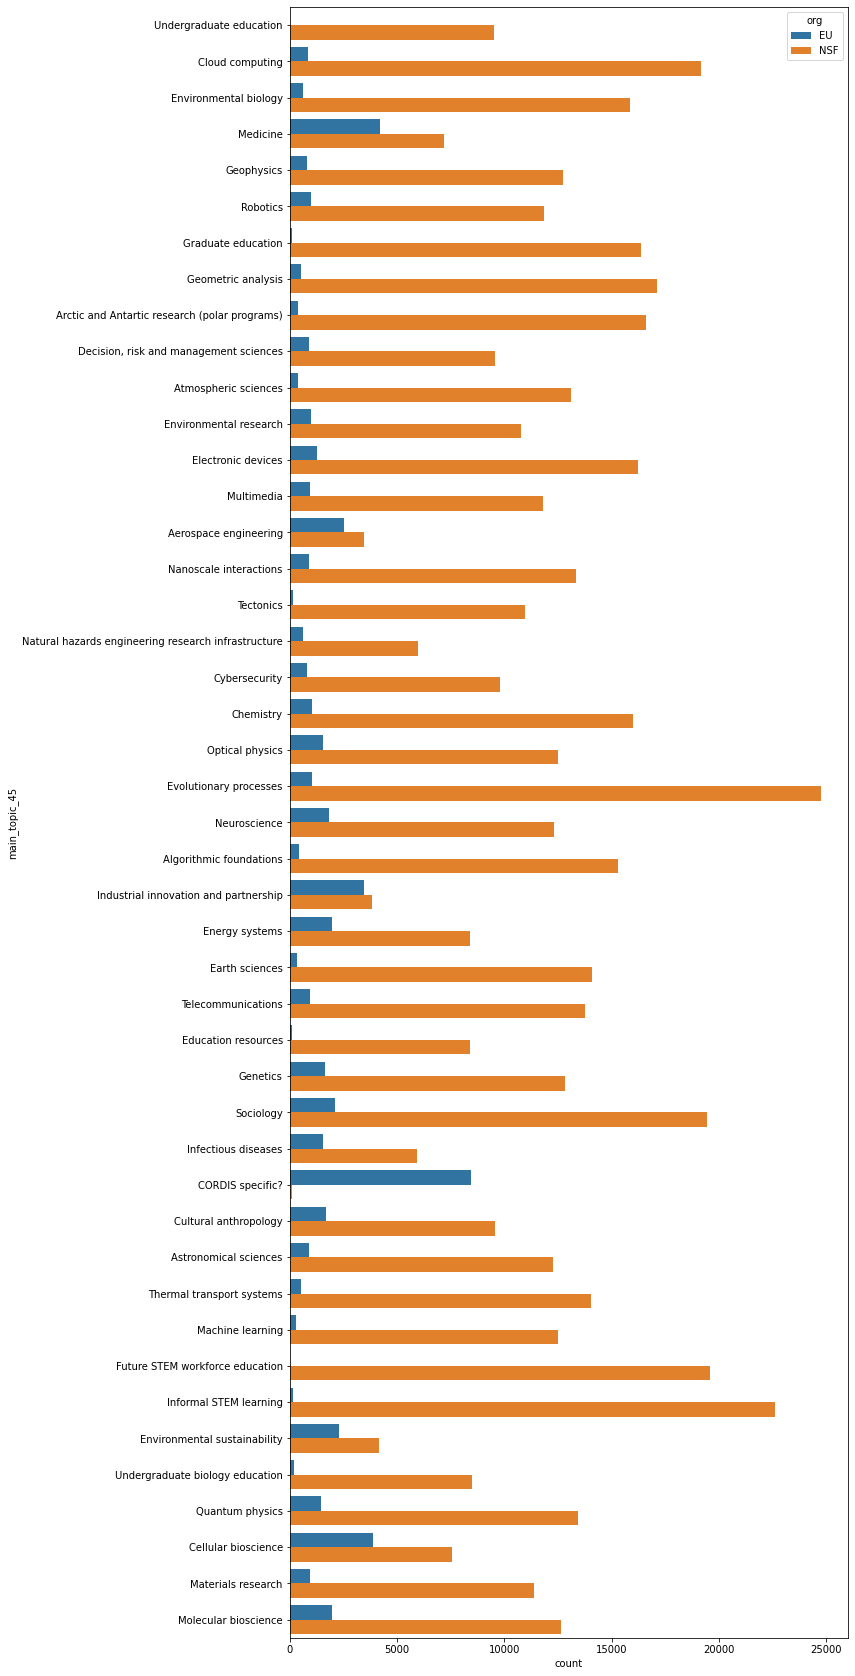

In [73]:
fig, axes = plt.subplots(1, 1, figsize=(10, 30), sharex=True)
ids_order = [str(x) for x in list(range(45))]
sns.countplot(data = corpusdata, y='main_topic_45', hue='org', order=tpc_descriptions)
plt.show()

In [80]:
cordis = pd.read_csv("data/cordis/cordis.csv",usecols=['id','totalCost','startYear'])
nsf = pd.read_csv('data/nsf/nsf.csv',usecols=['AwardID','AwardAmount','awardEffectiveYear'])